In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import gc

sns.set(style="darkgrid")
import warnings

warnings.filterwarnings('ignore')
import statsmodels.tsa.api as smtsa

In [2]:
def gen_random_walk(
    num = 1000,
    mean = 0,
    sigma = 0.1,
    min_val = -100,
    max_val = 100
):
    vals = [mean]
    curr = mean
    for i in range(num-1):
        delta = np.random.normal(mean,sigma,1)[0]    
        if (delta>0 and curr+delta>max_val) or (delta<0 and curr+delta<min_val): 
            delta = -delta     
        curr = curr+delta        
        vals.append(curr)
        
    return np.array(vals)

from scipy.sparse.csgraph import connected_components

def calculate_entropy(df,threshold,fillna = 1):
    #there two reasons when na occurs in the correlation matrix
    # 1: no variane
    # 2: missing values    
    if fillna is not None:        
        corr = (np.abs(df.corr().fillna(fillna).values)>threshold).astype(int)
    else:
        corr = (np.abs(df.corr().values)>threshold).astype(int)
    _, labels = connected_components(corr)
    _, count = np.unique(labels, return_counts=True)
    count_norm = count / count.sum()    
    return -np.nansum(count_norm*np.log2(count_norm))
    
def get_entropy(df, sequence_length, step=1, corr_threshold=0.5, check_na = False):    
    if check_na: assert np.any(df.isna())==False        
    
    entropy_dict = {'index':[], 'structural_entropy':[]}

    for i in range(sequence_length, df.shape[0], step):        
        entropy_dict['index'].append(df.index[i])
        entropy_dict['structural_entropy'].append(calculate_entropy(df.iloc[i-sequence_length:i-1,:],corr_threshold))        

    return pd.Series(entropy_dict['structural_entropy'], index=entropy_dict['index'])

In [3]:
series_num = 10
total_len = 1000
series = []

for _ in range(3):  series.append(np.random.normal(0,1, total_len))       
for _ in range(2):  series.append(gen_random_walk(total_len))        

ar = np.r_[1, -0.5]
ma = np.r_[1, 0.5]
series.append(smtsa.arma_generate_sample(ar=ar, ma=ma, nsample=total_len)) 

df = pd.DataFrame(series).T    
df.shape

(1000, 6)

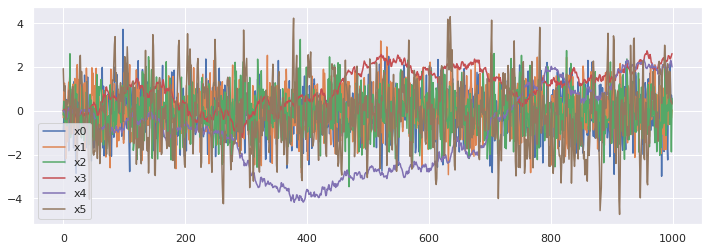

In [4]:
plt.figure(figsize=(12,4))
for col in df.columns:
    plt.plot(df[col], label=f'x{col}')
plt.legend()
plt.legend(loc='lower left')

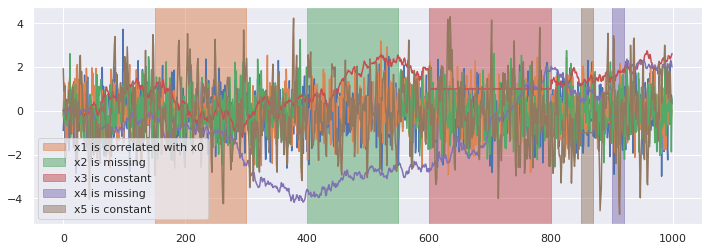

In [5]:
#define some anomaly regions
sections = []
# df.loc[150:300,1] = np.random.normal(0,1,151)
df.loc[150:300,1] = df.loc[150:300,0] * 0.5
sections.append(('x1 is correlated with x0',150,300))         

df.loc[400:550,2] = np.nan
sections.append(('x2 is missing',400,550))         

df.loc[600:800,3] = 1
sections.append(('x3 is constant',600,800))         

df.loc[900:920,4] = np.nan
sections.append(('x4 is missing',900,920))         

df.loc[850:870,5] = -1
sections.append(('x5 is constant',850,870))         

plt.figure(figsize=(12,4))
for col in df.columns:
    plt.plot(df[col])
for i,s in enumerate(sections):
    plt.axvspan(s[1],s[2],label=s[0],color=sns.color_palette()[i+1], alpha=0.5)
plt.legend(loc='lower left')

In [7]:
df.loc[400:550,:].corr()

,0,1,2,3,4,5
0,1.000000,0.035565,NaN,0.019817,-0.002438,0.060167
1,0.035565,1.000000,NaN,0.014147,-0.000066,-0.043575
2,NaN,NaN,NaN,NaN,NaN,NaN
3,0.019817,0.014147,NaN,1.000000,0.890662,-0.019740
4,-0.002438,-0.000066,NaN,0.890662,1.000000,0.002128
5,0.060167,-0.043575,NaN,-0.019740,0.002128,1.000000


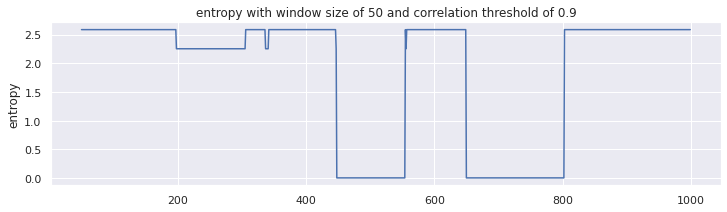

In [6]:
win_size = 50
corr_threshold = 0.9
plt.figure(figsize=(12,3))
entropy = get_entropy(df, win_size, 1, corr_threshold)
plt.ylabel('entropy')
plt.title(f'entropy with window size of {win_size} and correlation threshold of {corr_threshold}')
plt.plot(entropy)
plt.show()

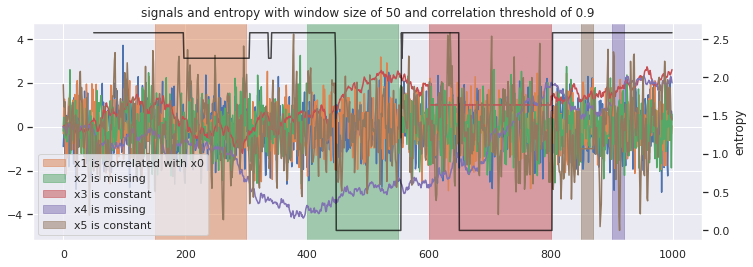

In [8]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(111)
for col in df.columns:
    ax1.plot(df[col])
for i,s in enumerate(sections):
    ax1.axvspan(s[1],s[2],label=s[0],color=sns.color_palette()[i+1], alpha=0.5)
    
ax1.legend(loc = 'lower left')        
ax2 = ax1.twinx()
ax2.plot(entropy, color='black', alpha=0.7)
ax2.set_ylabel('entropy')
ax2.grid(False)
plt.title(f'signals and entropy with window size of {win_size} and correlation threshold of {corr_threshold}')
plt.show()